## Getting the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzipping image data
import zipfile

# ---------train---------------
zippath = '/content/drive/MyDrive/sonification/train.zip'
targetfolder = '/content/drive/MyDrive/sonification/train'

with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall(targetfolder)

# --------validation---------------
zippath = '/content/drive/MyDrive/sonification/val.zip'
targetfolder = '/content/drive/MyDrive/sonification/validation'

with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall(targetfolder)

# -------------test---------------
zippath = '/content/drive/MyDrive/sonification/test.zip'
targetfolder = '/content/drive/MyDrive/sonification/test'

with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall(targetfolder)

FileNotFoundError: [Errno 2] No such file or directory: 'train_labels.txt'

In [ ]:
def load_list_from_txt(filename):
    with open(filename, 'r') as file:
        list_data = [line.strip() for line in file]
    return list_data

train_array = load_list_from_txt("/content/drive/MyDrive/sonification/train_labels.txt")
val_array = load_list_from_txt("/content/drive/MyDrive/sonification/val_labels.txt")
test_array = load_list_from_txt("/content/drive/MyDrive/sonification/test_labels.txt")

## Dataset preparation

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image

from __future__ import print_function
from __future__ import division
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

from tqdm import tqdm, trange

PyTorch Version:  2.4.0+cu121
Torchvision Version:  0.19.0+cu121


In [ ]:
# Convierte la lista de strings en una lista de enteros
train_array = list(map(int, train_array))
val_array = list(map(int, val_array))
test_array = list(map(int, test_array))

train_labels = np.array(train_array)
val_labels = np.array(val_array)
test_labels = np.array(test_array)

In [ ]:
print(type(train_labels))
print(train_labels)

<class 'numpy.ndarray'>
[4 3 2 1 1 0 3 0 2 3 3 1 0 2 1 2 1 0 3 1 3 3 2 4 1 4 1 1 2 1 1 3 4 3 4 0 0
 2 1 1 4 0 4 4 1 1 2 0 1 0 2 0 0 2 0 3 4 2 2 2 1 3 4 3 0 0 4 4 1 3 4 0 0 4
 2 3 1 2 2 1 0 3 1 3 2 2 1 0 2 4 2 3 4 2 0 0 1 3 4 1 1 4 2 3 3 0 1 2 0 4 3
 4 4 4 3 0 3 1 0 3 1 1 4 3 3 2 1 4 1 4 0 4 0 3 4 0 2 1 1 3 4 3 1 3 0 1 2 3
 1 2 3 1 2 1 1 4 2 1 1 3 0 2 0 3 0 0 1 2 2 4 2 3 1 3 2 1 2 3 1 2 4 0 3 1 4
 0 2 4 0 0 3 2 4 3 0 3 3 4 3 2 0 1 1 3 3 4 0 1 0 3 0 0 0 4 0 2]


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, labels, transform=None, is_train=True):
        self.image_folder = image_folder
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_folder, '{:04d}.jpg'.format(index))
        image = Image.open(img_path).convert("RGB")
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
# Getting mean and standard deviation for normalization
transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.ToTensor(),
])

img_dir = '/content/drive/MyDrive/sonification/train'

dataset = CustomDataset(image_folder=img_dir, labels=train_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

mean = 0.
std = 0.
n_samples = 0.

for images, _ in dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print(f'Mean: {mean}')
print(f'Std: {std}')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Mean: tensor([0.3234, 0.3234, 0.3234])
Std: tensor([0.0363, 0.0363, 0.0363])


In [ ]:
# Transformations (NO data augmentation)
transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.ToTensor(),
    #transforms.Grayscale(),      ###
    transforms.Normalize(mean=mean, std=std)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations (data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Grayscale(),      ###
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    #transforms.Grayscale(),      ###
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Files path
train_folder = '/content/drive/MyDrive/sonification/train'
val_folder = '/content/drive/MyDrive/sonification/validation'
test_folder = '/content/drive/MyDrive/sonification/test'

In [ ]:
train_dataset = CustomDataset(train_folder, train_labels, transform, is_train=True)
val_dataset = CustomDataset(val_folder, val_labels, transform, is_train=False)
test_dataset = CustomDataset(test_folder, test_labels, transform, is_train=False)

## Setup and model selection

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 5

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False #True

## DataLoaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {'train': train_loader, 'val': val_loader}

## CNN implementation functions

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, patience = 6):
    since = time.time()

    val_acc_history = []
    train_loss_history = []  # Train Loss history                         #
    val_loss_history = []  # Validation Loss history                      #

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss_sum = 0.0  #  Training loss acumulation variable   #

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate train loss                                #
                if phase == 'train':                                  #
                    train_loss_sum += loss.item() * inputs.size(0)    #

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)  #  save validation loss                    #

        train_loss = train_loss_sum / len(dataloaders['train'].dataset)  # Calculate train loss    #
        train_loss_history.append(train_loss)  # save train loss                               #
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history, val_loss_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:05<00:00, 95.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

## Model creation

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
torch.cuda.is_available()
print(device)
print(torch.version.cuda)

cuda:0
12.1


In [ ]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


## Training and evaluating

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
#model_ft, hist, train_l, val_l = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
model_ft, hist, train_l, val_l = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 1.3471 Acc: 0.4028
val Loss: 1.3777 Acc: 0.2857

Epoch 1/24
----------
train Loss: 1.2409 Acc: 0.4676
val Loss: 1.3246 Acc: 0.2857

Epoch 2/24
----------
train Loss: 1.2210 Acc: 0.4907
val Loss: 1.3015 Acc: 0.4000

Epoch 3/24
----------
train Loss: 1.1167 Acc: 0.5370
val Loss: 1.3574 Acc: 0.4000

Epoch 4/24
----------
train Loss: 1.0262 Acc: 0.6019
val Loss: 1.3272 Acc: 0.3714

Epoch 5/24
----------
train Loss: 0.9281 Acc: 0.6667
val Loss: 1.3047 Acc: 0.4000

Epoch 6/24
----------
train Loss: 0.8604 Acc: 0.6620
val Loss: 1.3486 Acc: 0.3429

Epoch 7/24
----------
train Loss: 0.7276 Acc: 0.7407
val Loss: 1.3241 Acc: 0.4286

Epoch 8/24
----------
train Loss: 0.6071 Acc: 0.8519
val Loss: 1.3402 Acc: 0.4286

Epoch 9/24
----------
train Loss: 0.4502 Acc: 0.8889
val Loss: 1.4779 Acc: 0.4000

Epoch 10/24
----------
train Loss: 0.4077 Acc: 0.9167
val Loss: 1.5214 Acc: 0.4000

Epoch 11/24
----------
train Loss: 0.2565 Acc: 0.9537
val Loss: 1.6850 Acc: 0.4000

Ep

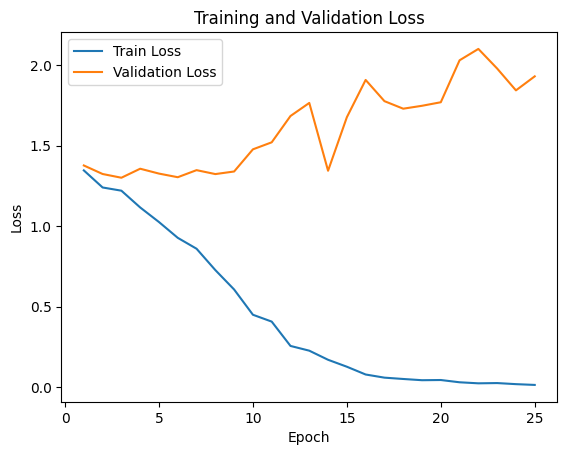

In [ ]:
import matplotlib.pyplot as plt

# Graficar las curvas de pérdida
plt.plot(range(1, num_epochs + 1), train_l, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_l, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/sonification/model.pth')
torch.save(hist, '/content/drive/MyDrive/sonification/hist.pth')
torch.save(train_l, '/content/drive/MyDrive/sonification/train_loss_.pth')
torch.save(val_l, '/content/drive/MyDrive/sonification/val_loss_.pth')

In [ ]:
hist_path = '/content/drive/MyDrive/sonification/hist.pth'
hist = torch.load(hist_path)
model_path = '/content/drive/MyDrive/sonification/model.pth'
model_ft = torch.load(model_path)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

<ipython-input-8-3e18bf718433>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(hist_path)
<ipython-input-8-3e18bf718433>:4: FutureWarning: You are using `

In [ ]:
print(type(hist))
print(hist)

<class 'list'>
[tensor(0.2857, device='cuda:0', dtype=torch.float64), tensor(0.2857, device='cuda:0', dtype=torch.float64), tensor(0.4000, device='cuda:0', dtype=torch.float64), tensor(0.4000, device='cuda:0', dtype=torch.float64), tensor(0.3714, device='cuda:0', dtype=torch.float64), tensor(0.4000, device='cuda:0', dtype=torch.float64), tensor(0.3429, device='cuda:0', dtype=torch.float64), tensor(0.4286, device='cuda:0', dtype=torch.float64), tensor(0.4286, device='cuda:0', dtype=torch.float64), tensor(0.4000, device='cuda:0', dtype=torch.float64), tensor(0.4000, device='cuda:0', dtype=torch.float64), tensor(0.4000, device='cuda:0', dtype=torch.float64), tensor(0.4286, device='cuda:0', dtype=torch.float64), tensor(0.5429, device='cuda:0', dtype=torch.float64), tensor(0.5143, device='cuda:0', dtype=torch.float64), tensor(0.4571, device='cuda:0', dtype=torch.float64), tensor(0.4286, device='cuda:0', dtype=torch.float64), tensor(0.4286, device='cuda:0', dtype=torch.float64), tensor(0.457

## Validation Predictions (yeaah)

In [ ]:
model_path = '/content/drive/MyDrive/sonification/model.pth'

In [ ]:
model = torch.load(model_path)

<ipython-input-59-f734c043ce43>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [ ]:
predictions = []

with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())

In [ ]:
print(predictions)

[0, 2, 1, 4, 1, 3, 1, 1, 1, 2, 1, 2, 3, 2, 0, 2, 3, 4, 1, 1, 4, 3, 0, 1, 1, 3, 3, 1, 0, 4, 0, 2, 2, 1, 1]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix_train = confusion_matrix(val_labels, predictions, normalize="true")
accuracy_train = accuracy_score(val_labels, predictions)

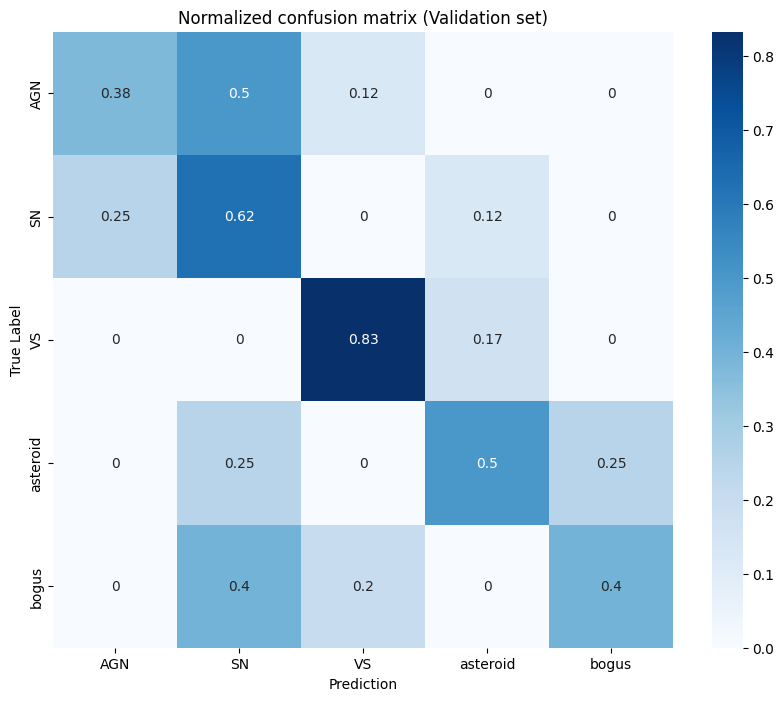

Accuracy in validation set 0.5428571428571428


In [ ]:
import seaborn as sns

class_encoding = {"AGN" : 0, "SN" : 1, "VS": 2, "asteroid" : 3, "bogus" :4}

index_to_label = {v: k for k, v in class_encoding.items()}

labels = [index_to_label[i] for i in range(len(class_encoding))]

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_train, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Normalized confusion matrix (Validation set)")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()

print("Accuracy in validation set", accuracy_train)

## Test  Predictions (yeaah x2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, labels, transform=None, is_train=True):
        self.image_folder = image_folder
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_folder, '{:04d}.jpg'.format(index))
        image = Image.open(img_path).convert("RGB")
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
# Transformaciones de las imágenes (sin data augmentation)
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Files path
train_folder = '/content/drive/MyDrive/sonification/train'
val_folder = '/content/drive/MyDrive/sonification/validation'
test_folder = '/content/drive/MyDrive/sonification/test'

In [ ]:
test_dataset = CustomDataset(test_folder, test_labels, transform, is_train=False)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
hist_path = '/content/drive/MyDrive/sonification/hist.pth'
hist = torch.load(hist_path)
model_path = '/content/drive/MyDrive/sonification/model.pth'
model_ft = torch.load(model_path)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

<ipython-input-52-3e18bf718433>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(hist_path)
<ipython-input-52-3e18bf718433>:4: FutureWarning: You are using

In [ ]:
model = torch.load(model_path)

<ipython-input-53-f734c043ce43>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [ ]:
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())

In [ ]:
print(predictions)

[3, 1, 1, 1, 4, 2, 1, 4, 1, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 4, 4, 1, 1, 4, 1, 1, 2, 1, 1, 1, 3, 4, 4, 1, 1, 1, 2, 2, 4, 4, 1, 1, 2, 2, 1, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 4, 1, 4, 1, 1, 1, 1, 2, 4, 4, 3, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 2, 3, 1, 3, 1, 1, 4, 1]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix_train = confusion_matrix(test_labels, predictions, normalize="true")
accuracy_train = accuracy_score(test_labels, predictions)

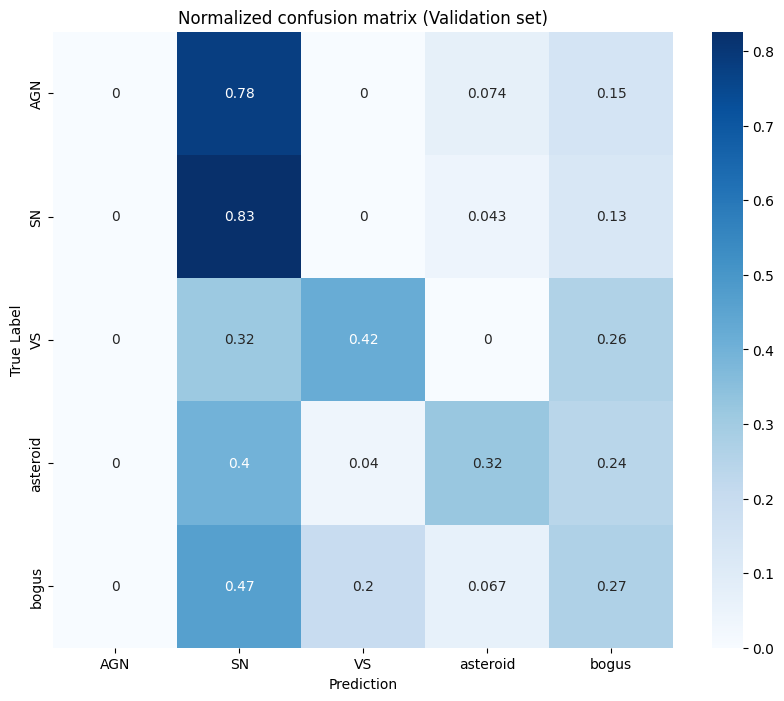

Accuracy in validation set 0.3577981651376147


In [ ]:
import seaborn as sns

class_encoding = {"AGN" : 0, "SN" : 1, "VS": 2, "asteroid" : 3, "bogus" :4}

index_to_label = {v: k for k, v in class_encoding.items()}

labels = [index_to_label[i] for i in range(len(class_encoding))]

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_train, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Normalized confusion matrix (Validation set)")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()

print("Accuracy in validation set", accuracy_train)

##Extra

In [ ]:
!unzip '/content/drive/MyDrive/proyecto_inteligencia/heatmap/validacion.zip'

Archive:  /content/drive/MyDrive/proyecto_inteligencia/heatmap/validacion.zip
   creating: content/validacion/
  inflating: content/validacion/val_1008.png  
  inflating: content/validacion/val_0181.png  
  inflating: content/validacion/val_1849.png  
  inflating: content/validacion/val_0770.png  
  inflating: content/validacion/val_1951.png  
  inflating: content/validacion/val_0578.png  
  inflating: content/validacion/val_0849.png  
  inflating: content/validacion/val_0460.png  
  inflating: content/validacion/val_0432.png  
  inflating: content/validacion/val_0733.png  
  inflating: content/validacion/val_0322.png  
  inflating: content/validacion/val_0737.png  
  inflating: content/validacion/val_0374.png  
  inflating: content/validacion/val_1933.png  
  inflating: content/validacion/val_1103.png  
  inflating: content/validacion/val_1979.png  
  inflating: content/validacion/val_0848.png  
  inflating: content/validacion/val_1354.png  
  inflating: content/validacion/val_0615.pn

In [ ]:
# Transformaciones de las imágenes (sin data augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Grayscale(),      ###
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32

# Rutas de las carpetas y archivos

val_folder = '/content/content/validacion'
val_labels_file = '/content/drive/MyDrive/proyecto_inteligencia/val_labels.npy'

In [ ]:
val_dataset = CustomDataset(val_folder, val_labels_file, transform, is_train=False)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model_path = '/content/drive/MyDrive/proyecto_inteligencia/model_vgg_2.pth'
hist_path = '/content/drive/MyDrive/proyecto_inteligencia/hist_vgg_2.pth'
train_l_path = '/content/drive/MyDrive/proyecto_inteligencia/train_loss_vgg_2.pth'
val_l_path = '/content/drive/MyDrive/proyecto_inteligencia/val_loss_vgg_2.pth'

train_l = torch.load(train_l_path)
val_l = torch.load(val_l_path)
num_epochs = 20

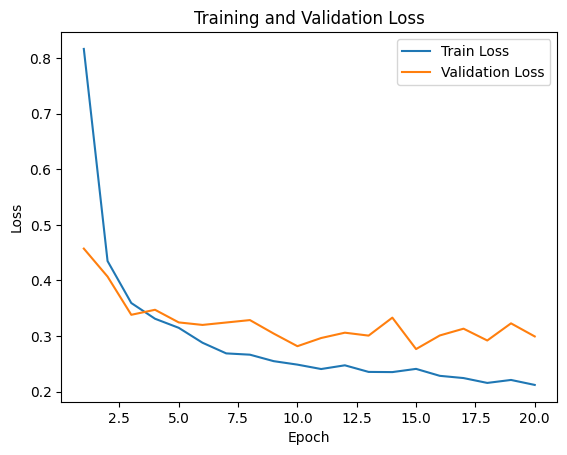

In [ ]:
import matplotlib.pyplot as plt

# Graficar las curvas de pérdida
plt.plot(range(1, num_epochs + 1), train_l, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_l, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model = torch.load(model_path)

In [ ]:
predictions = []

with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())

In [ ]:
print(predictions)

[0, 0, 5, 3, 5, 5, 0, 1, 4, 1, 5, 2, 1, 4, 4, 0, 0, 5, 5, 5, 2, 1, 1, 1, 3, 1, 0, 3, 5, 3, 1, 2, 5, 4, 3, 1, 5, 4, 5, 3, 0, 1, 4, 1, 4, 3, 4, 4, 3, 3, 5, 2, 3, 2, 5, 1, 0, 4, 3, 3, 2, 1, 0, 1, 4, 0, 5, 3, 5, 4, 5, 4, 0, 1, 0, 5, 5, 4, 1, 2, 2, 4, 2, 5, 5, 5, 5, 5, 5, 4, 0, 1, 3, 5, 0, 2, 4, 5, 1, 3, 2, 4, 3, 0, 2, 3, 5, 3, 4, 5, 3, 5, 5, 0, 4, 3, 4, 3, 3, 3, 0, 2, 4, 3, 4, 5, 5, 4, 4, 2, 3, 0, 3, 5, 3, 3, 5, 5, 0, 1, 4, 1, 5, 5, 3, 5, 1, 5, 4, 4, 3, 5, 5, 0, 5, 3, 1, 3, 5, 2, 5, 4, 5, 2, 2, 3, 1, 1, 4, 5, 2, 1, 4, 5, 5, 2, 0, 4, 3, 4, 4, 3, 5, 3, 5, 4, 2, 1, 0, 4, 2, 0, 0, 2, 2, 2, 1, 4, 3, 3, 5, 1, 4, 1, 1, 1, 1, 5, 2, 3, 4, 2, 1, 2, 1, 2, 5, 5, 1, 2, 3, 5, 5, 4, 0, 1, 5, 0, 4, 0, 0, 5, 5, 4, 3, 2, 2, 1, 3, 1, 4, 5, 3, 1, 3, 2, 0, 4, 0, 5, 0, 0, 4, 5, 4, 4, 5, 2, 4, 4, 3, 1, 0, 5, 5, 1, 2, 4, 4, 0, 4, 0, 3, 3, 0, 4, 3, 0, 3, 3, 0, 5, 4, 4, 4, 5, 5, 3, 0, 0, 5, 5, 1, 3, 2, 2, 4, 3, 5, 5, 3, 5, 4, 3, 5, 4, 3, 4, 0, 3, 0, 2, 2, 1, 0, 1, 5, 3, 4, 3, 4, 5, 2, 5, 2, 0, 3, 5, 5, 4, 4, 4, 1, 

In [ ]:
pred = np.array(predictions)

pred += 1
print(pred)

[1 1 6 ... 6 5 6]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix_train = confusion_matrix(val_labels, pred, normalize="true")
accuracy_train = accuracy_score(val_labels, pred)



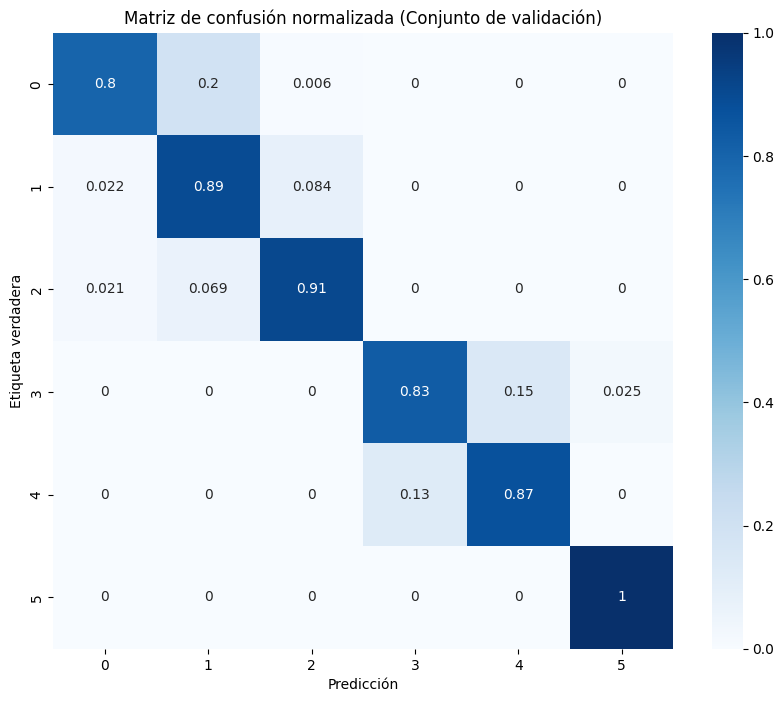

Accuracy en el conjunto de validación: 0.8855


In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_train, annot=True, cmap="Blues")
plt.title("Matriz de confusión normalizada (Conjunto de validación)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.show()

print("Accuracy en el conjunto de validación:", accuracy_train)